In [1]:
import random
from typing import Optional

import gymnasium as gym
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import gridworlds.envs.gridworld as gridworld

# Environment Adaption

The Wrapper allows to sweep through the entire state space.

In [2]:
class GridWorldWrapper(gym.Wrapper):
    def __init__(self, env: gridworld.GridWorld):
        super().__init__(env)
        self.env = env

    def all_states(self):
        """Generator to iterate over all states in the grid."""
        for i in range(self.env.unwrapped.size):
            for j in range(self.env.unwrapped.size):
                yield np.array([i, j])

    def get_neighbors(self, state: np.ndarray):
        """Returns a list of neighboring states for the given state."""
        neighbors = []
        row, col = state
        moves = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        actions = [gridworld.UP, gridworld.DOWN, gridworld.RIGHT, gridworld.LEFT]

        for (dr, dc), action in zip(moves, actions):
            new_row, new_col = row + dr, col + dc

            # special states
            if row == 0 and col == 1:
                neighbors.append((np.array([4, 1]), action))
            elif row == 0 and col == 3:
                neighbors.append((np.array([2, 3]), action))

            # normal states
            else:
                # Check boundaries
                if (
                    0 <= new_row < self.env.unwrapped.size
                    and 0 <= new_col < self.env.unwrapped.size
                ):
                    neighbors.append((np.array([new_row, new_col]), action))
                else:
                    # If the move is out of bounds, stay in the same state
                    neighbors.append((state, action))

        return neighbors

    def lookahead(self, state: np.ndarray):
        """Perform lookahead for each action at the provided state.

        Returns:
            dict of {action: (next_state, reward)}
        """
        results = {}

        for next_state, action in self.get_neighbors(state):
            # Temporarily set the environment state for consistent lookahead
            original_state = self.env.unwrapped.state
            self.env.unwrapped.state = state

            # Calculate reward for the transition
            reward = self.env.unwrapped._get_reward(state, action)
            results[action] = (next_state, reward)

            # Restore original state
            self.env.unwrapped.state = original_state

        return results

# RL Utils

In [3]:
class Actor:
    policy_types = ["uniform", "predefined"]

    def __init__(self, num_states, num_actions, action_probs=None):
        self.num_states = num_states
        self.num_actions = num_actions

        if action_probs is None:
            # Uniform policy
            self._policy = np.full((*num_states, num_actions), 1 / num_actions)
            self._policy_type = "uniform"
        else:
            # Predefined policy
            self._policy_type = "predefined"

            if isinstance(action_probs, list) or isinstance(action_probs, np.ndarray):
                # Ensure `action_probs` is properly shaped and matches state-action space
                self._policy = np.array(action_probs)
                if self._policy.shape != (*num_states, num_actions):
                    raise ValueError(
                        "action_probs must match the shape of (num_states,..., num_actions)"
                    )
            else:
                raise ValueError("action_probs must be a list or a NumPy ndarray")

    def set_probs(self, state, probs):
        """Sets the action probabilities for a given state"""
        self._policy[tuple(state)] = probs

    def greedy_action_probs(self, state):
        """Returns actions with the highest probability for the given state, along their actual probability"""
        state_policy = self._policy[tuple(state)]
        max_prob = np.max(state_policy)
        actions_with_max_prob = {
            action: prob for action, prob in enumerate(state_policy) if prob == max_prob
        }

        return actions_with_max_prob

    def greedy_action(self, state):
        actions_with_max_prob = self.greedy_action_probs(state)

        if len(actions_with_max_prob) > 1:
            pobs_best_actions_list = list(actions_with_max_prob.items())
            greedy_action = random.choice(pobs_best_actions_list)[0]
        else:
            greedy_action = next(iter(actions_with_max_prob.items()))[0]

        return greedy_action

    
    def epsilon_greedy_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action_values = self.get_actions(state)
            action = max(action_values, key=action_values.get)

        return action


    def get_actions(self, state):
        """Returns a dictionary of actions with corresponding probabilities for the given state"""

        return {action: prob for action, prob in enumerate(self._policy[tuple(state)])}

    def sample_action(self, state):
        """Samples an action according to the probabilities set for each action"""       
        return np.random.choice(self.num_actions, p=np.squeeze(self._policy[tuple(state)]))

    def update_policy_epsilon_greedy(self, state, action_values, epsilon):
        """Updates the policy for a given state based on epsilon-greedy strategy"""
        max_value = np.max(action_values)
        best_actions = np.argwhere(action_values == max_value).flatten()
        
        # Equal probability for all the best actions
        equal_prob = (1.0 - epsilon) / len(best_actions)
        probs = np.ones(self.num_actions) * (epsilon / self.num_actions)
        probs[best_actions] += equal_prob

        # Update the policy probabilities for the given state
        probs /= probs.sum() # Ensure normalization
        self.set_probs(state, probs)

    def update_policy_greedy(self, state, action_values):
        max_value = np.max(action_values)
        best_actions = np.argwhere(action_values == max_value).flatten()
        
        # consider case with 2 max actions
        equal_prob = 1.0 / len(best_actions)
        probs = np.zeros(self.num_actions)
        probs[best_actions] += equal_prob

        probs /= probs.sum()
        self.set_probs(state, probs)



In [4]:
class StateValueFunction:
    def __init__(self, state_space_shape, default_value: float = 0.0):
        """
        Initializes the state value function with a NumPy array for the given state space size.

        Args:
            state_space_shape: A tuple defining the size of the state space (e.g., (n, n) for an n x n grid).
            default_value (float): The default value to initialize each state.
        """
        self.values = np.full(state_space_shape, default_value, dtype=float)

    def get_value(self, state) -> float:
        """Returns the value of the given state"""
        return self.values[tuple(state)]

    def set_value(self, state, value: float):
        """Sets the value for a given state"""
        self.values[tuple(state)] = value

    def get_copy(self):
        """Create a copy of the value function instance."""
        from copy import deepcopy

        return deepcopy(self)


class ActionValueFunction:
    def __init__(self, state_space_shape, n_actions: int, default_value: float = 0.0):
        """Initializes the action-value function with a NumPy array for the given state space and action size"""
        self.values = np.full(
            tuple(state_space_shape) + (n_actions,), default_value, dtype=float
        )

    def get_action_values_from_state(self, state):
        """Return the action values for a state"""
        return self.values[tuple(state)]

    def get_value(self, state, action) -> float:
        """Returns the value of the given state-action pair"""
        return self.values[tuple(state) + (action,)]

    def set_value(self, state, action, value: float):
        """Sets the value for a given state-action pair"""
        self.values[tuple(state) + (action,)] = value

    def get_copy(self):
        """Create a copy of the value function instance."""
        from copy import deepcopy

        return deepcopy(self)

## Plotting

In [5]:
# Overlay the policy arrows for each state
DIRECTIONS = {
    0: (-1, 0),  # UP
    1: (0, 1),  # RIGHT
    2: (1, 0),  # DOWN
    3: (0, -1),  # LEFT
}


def plot_gridworld_state(value_function, state_space_shape, actor):
    """Generate a heatmap for the value function"""

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        value_function.values,
        annot=True,
        cmap="YlGnBu",
        cbar=True,
        square=True,
        fmt=".2f",
    )
    plt.title("State Value Function with Policy Directions")
    ax.figure.axes[-1].set_ylabel("State Value", rotation=90, size=12)

    # Iterate over every state in the grid
    for row in range(state_space_shape[0]):
        for col in range(state_space_shape[1]):
            state = (row, col)

            # Get the most probable action(s)
            max_actions = actor.greedy_action_probs(state)

            # Plot arrows for each action with max probability
            for action in max_actions:
                dx, dy = DIRECTIONS[action]
                plt.arrow(
                    col + 0.5 + dy * 0.2,
                    row + 0.5 + dx * 0.2,
                    dy * 0.15,
                    dx * 0.15,
                    color="black",
                    head_width=0.1,
                    head_length=0.1,
                )

    # Define ticks and labels
    plt.xticks(
        ticks=np.arange(0.5, state_space_shape[1], 1),
        labels=np.arange(state_space_shape[1]),
    )
    plt.yticks(
        ticks=np.arange(0.5, state_space_shape[0], 1),
        labels=np.arange(state_space_shape[0]),
    )

    plt.show()


def plot_gridworld_action(action_value_function, state_space_shape, actor):
    n_actions = action_value_function.values.shape[-1]

    # Define grid for the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    dx_map = {0: -1, 1: 0, 2: 1, 3: 0}
    dy_map = {0: 0, 1: 1, 2: 0, 3: -1}

    # Get the range of action values for normalization
    vmin, vmax = np.min(action_value_function.values), np.max(
        action_value_function.values
    )
    cmap = plt.cm.YlGnBu

    for row in range(state_space_shape[0]):
        for col in range(state_space_shape[1]):
            state = (row, col)
            action_values = [
                action_value_function.get_value(state, a) for a in range(n_actions)
            ]

            # Normalize action values to [0, 1] range for color mapping
            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            colors = [cmap(norm(value)) for value in action_values]

            # Plot background color for each action
            for action in range(n_actions):
                dx, dy = dx_map[action] * 0.36, dy_map[action] * 0.36
                rect = plt.Rectangle(
                    (col + dy + 0.375, row + dx + 0.375),
                    0.25,
                    0.25,
                    color=colors[action],
                    alpha=0.5,
                )
                ax.add_patch(rect)
                ax.text(
                    col + 0.5 + dy,
                    row + 0.5 + dx,
                    f"{action_values[action]:.2f}",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="black",
                )

            # Overlay policy arrows for the most probable action(s)
            max_actions = actor.greedy_action_probs(state)
            for action in max_actions:
                dx, dy = DIRECTIONS[action]
                ax.arrow(
                    col + 0.5,
                    row + 0.5,
                    dy * 0.1,
                    dx * 0.1,
                    color="red",
                    head_width=0.1,
                    head_length=0.1,
                )

    # Fancy plotting
    ax.set_xticks(np.arange(0.5, state_space_shape[1], 1))
    ax.set_yticks(np.arange(0.5, state_space_shape[0], 1))
    ax.set_xticklabels(np.arange(state_space_shape[1]))
    ax.set_yticklabels(np.arange(state_space_shape[0]))

    ax.hlines(
        np.arange(1, state_space_shape[0]),
        xmin=0,
        xmax=state_space_shape[1],
        color="black",
        linewidth=0.5,
    )
    ax.vlines(
        np.arange(1, state_space_shape[1]),
        ymin=0,
        ymax=state_space_shape[0],
        color="black",
        linewidth=0.5,
    )

    ax.invert_yaxis()  # Ensure (0,0) is at the top left
    ax.set_title("Action Value Function with Policy Directions")
    plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax,
        orientation="vertical",
        label="Action Value",
    )

    plt.show()

# GPI with State Values

In [13]:
class GPIstate:
    def __init__(
        self,
        actor: Actor,
        value_fct: StateValueFunction,
        env: gym.Env,
        grid_shape: np.ndarray,
        gamma=0.8,
        theta: Optional[int] = 0.1,
    ):
        self.actor = actor
        self.env = env
        self.value_function = value_fct
        self.grid_shape = grid_shape

        self.gamma = gamma
        self.theta = theta

    def policy_evaluation(self, max_iterations=None):
        delta = float("inf")
        if max_iterations is None:
            max_iterations = float("inf")

        iteration = 0
        while not delta < self.theta and not max_iterations <= iteration:
            delta = 0.0
            old_value_function = self.value_function.get_copy()

            # Sweep over all states
            for state in self.env.all_states():
                state_value_tmp = old_value_function.get_value(state)
                transitions = self.env.lookahead(state)
                actions = self.actor.get_actions(state)

                # calculate state value with lookahead
                state_value = 0.0
                for action, action_prob in actions.items():
                    next_state, reward = transitions[action]
                    state_value_prime = old_value_function.get_value(next_state)
                    state_value += action_prob * (
                        reward + self.gamma * state_value_prime
                    )

                self.value_function.set_value(state, state_value)

                # termination criterion
                delta = max(delta, abs(state_value_tmp - state_value))

            print("Iteration: ", iteration, " Final Delta: ", delta)
            iteration += 1

        return self.value_function

    def policy_improvement(self):
        actions_comparison = []

        for state in self.env.all_states():
            # calculate action values
            transitions = self.env.lookahead(state)
            actions_tmp = self.actor.get_actions(state)
            actions_value = []

            for action, action_prob_tmp in actions_tmp.items():
                next_state, reward = transitions[action]
                state_value_prime = self.value_function.get_value(next_state)
                action_value = reward + self.gamma * state_value_prime
                actions_value.append(action_value)

            # update action probabilities greedy based on action value
            max_actions_val = np.max(actions_value)
            max_actions_idc = [
                idx
                for idx, action_value in enumerate(actions_value)
                if action_value == max_actions_val
            ]

            actions_prob = []
            tmp_prob = 1 / len(max_actions_idc)

            for action, action_prob_tmp in actions_tmp.items():
                if action in max_actions_idc:
                    action_prob = tmp_prob
                else:
                    action_prob = 0.0

                actions_prob.append(action_prob)
                actions_comparison.append(np.isclose(action_prob_tmp, action_prob))

            self.actor.set_probs(state, actions_prob)

        policy_stable = all(actions_comparison)
        print("Policy Stable: ", policy_stable)

        return policy_stable

    def train_policy_iteration(
        self,
        num_max_iterations=100,
    ):
        iteration = 0
        policy_stable = False

        print("[Info] - Starting Policy Iteration Algorithm")

        while iteration < num_max_iterations and not policy_stable:
            print("[Info] - Policy Iteration")
            print("Iteration: ", iteration)

            print("[Info] - Policy Evaluation")
            self.policy_evaluation()

            print("[Info] - Policy Improvement")
            policy_stable = self.policy_improvement()

            plot_gridworld_state(self.value_function, self.grid_shape, self.actor)

            iteration += 1

        return self.value_function, self.actor

    def train_value_iteration(self, num_max_iterations=100):
        iteration = 0
        policy_stable = False

        print("[Info] - Starting Value Iteration Algorithm")

        while iteration < num_max_iterations and not policy_stable:
            print("[Info] - Policy Iteration")
            print("Iteration: ", iteration)

            print("[Info] - Policy Evaluation")
            self.policy_evaluation(max_iterations=1)

            print("[Info] - Policy Improvement")
            policy_stable = self.policy_improvement()

            plot_gridworld_state(self.value_function, self.grid_shape, self.actor)

            iteration += 1

        return self.value_function, self.actor

## Policy Iteration

In [ ]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0])))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = StateValueFunction(state_space_shape=grid_shape)
algorithm = GPIstate(actor, value_function, env, grid_shape)

algorithm.train_policy_iteration()

## Value Iteration

In [ ]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0])))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = StateValueFunction(state_space_shape=grid_shape)
algorithm = GPIstate(actor, value_function, env, grid_shape)

algorithm.train_value_iteration()

# GPI with Action Values

In [9]:
from typing import Optional, Union


class GPIaction:
    def __init__(
        self,
        actor: Actor,
        value_fct: ActionValueFunction,
        env: gym.Env,
        grid_shape: np.ndarray,
        gamma=0.8,
        theta: Optional[int] = 0.1,
    ):
        self.actor = actor
        self.env = env
        self.value_function = value_fct
        self.grid_shape = grid_shape

        self.gamma = gamma
        self.theta = theta

    def policy_evaluation(self, max_iterations=None):
        delta = float("inf")

        if max_iterations is None:
            max_iterations = float("inf")

        iteration = 0
        while not delta < self.theta and not max_iterations <= iteration:
            # Sweep over all states
            delta = 0.0
            old_value_function = self.value_function.get_copy()

            for state in self.env.all_states():
                transitions = self.env.lookahead(state)

                for action, (next_state, reward) in transitions.items():

                    state_value_tmp = 0.0
                    for action_tmp, action_prob_tmp in self.actor.get_actions(
                        next_state
                    ).items():
                        state_value_tmp += (
                            action_prob_tmp
                            * old_value_function.get_value(next_state, action_tmp)
                        )

                    action_value = reward + self.gamma * state_value_tmp

                    self.value_function.set_value(state, action, action_value)

                    delta = max(
                        delta,
                        abs(old_value_function.get_value(state, action) - action_value),
                    )

            print("Iteration: ", iteration, " Final Delta: ", delta)

            iteration += 1

        return self.value_function

    def policy_improvement(self):
        actions_comparison = []

        for state in self.env.all_states():
            # calculate action values
            actions_tmp = self.actor.get_actions(state)
            actions_value = self.value_function.get_action_values_from_state(state)

            # update action probabilities greedy based on action values
            max_actions_val = np.max(actions_value)
            max_actions_idc = [
                idx
                for idx, action_value in enumerate(actions_value)
                if action_value == max_actions_val
            ]

            actions_prob = []
            tmp_prob = 1 / len(max_actions_idc)

            for action, action_prob_tmp in actions_tmp.items():
                if action in max_actions_idc:
                    action_prob = tmp_prob
                else:
                    action_prob = 0.0

                actions_prob.append(action_prob)
                actions_comparison.append(np.isclose(action_prob_tmp, action_prob))

            self.actor.set_probs(state, actions_prob)

        policy_stable = all(actions_comparison)
        print("Policy Stable: ", policy_stable)

        return policy_stable

    def train_policy_iteration(
        self,
        num_max_iterations=100,
    ):
        iteration = 0
        policy_stable = False

        print("[Info] - Starting Policy Iteration Algorithm")

        while iteration < num_max_iterations and not policy_stable:
            print("[Info] - Policy Iteration")
            print("Iteration: ", iteration)

            print("[Info] - Policy Evaluation")
            self.policy_evaluation()

            print("[Info] - Policy Improvement")
            policy_stable = self.policy_improvement()

            plot_gridworld_action(self.value_function, self.grid_shape, self.actor)

            iteration += 1

        return self.value_function, self.actor

    def train_value_iteration(self, num_max_iterations=100):
        iteration = 0
        policy_stable = False

        print("[Info] - Starting Value Iteration Algorithm")

        while iteration < num_max_iterations and not policy_stable:
            print("[Info] - Policy Iteration")
            print("Iteration: ", iteration)

            print("[Info] - Policy Evaluation")
            self.policy_evaluation(max_iterations=1)

            print("[Info] - Policy Improvement")
            policy_stable = self.policy_improvement()

            plot_gridworld_action(self.value_function, self.grid_shape, self.actor)

            iteration += 1

        return self.value_function, self.actor

## Policy Iteration

In [ ]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0])))
env.reset()

grid_shape = env.observation_space.high + 1
num_actions = env.action_space.n

actor = Actor(num_states=grid_shape, num_actions=num_actions)
value_function = ActionValueFunction(
    state_space_shape=grid_shape, n_actions=num_actions
)
algorithm = GPIaction(actor, value_function, env, grid_shape)

algorithm.train_policy_iteration()

## Value Iteration

In [ ]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0])))
env.reset()

grid_shape = env.observation_space.high + 1
num_actions = env.action_space.n

actor = Actor(num_states=grid_shape, num_actions=num_actions)
value_function = ActionValueFunction(
    state_space_shape=grid_shape, n_actions=num_actions
)
algorithm = GPIaction(actor, value_function, env, grid_shape)

algorithm.train_value_iteration()

# Monte Carlo


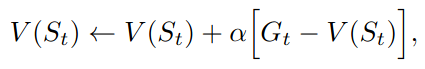

In [12]:
class MC():
    """Collection of Monte Carlo Algorithms for RL"""

    def __init__(
        self,
        actor: Actor,
        value_fct: ActionValueFunction,
        env: gym.Env,
        actor_target: Optional[Actor] = None,
        gamma: float = 0.8,
        epsilon: float = 0.1,
    ):
        self.actor = actor
        self.actor_target = actor_target
        self.env = env
        self.value_function = value_fct

        self.gamma = gamma      # discount
        self.epsilon = epsilon  # greedy policy

        # data containers
        self.episode_data = []
        
        state_space_shape = (env.unwrapped.size, env.unwrapped.size)
        n_actions = env.action_space.n

        self.first_visit = np.zeros((*state_space_shape, n_actions), dtype=bool)
        self.returns_count = np.zeros((*state_space_shape, n_actions))
        self.returns_sum = np.zeros((*state_space_shape, n_actions))
        self.importance_weights = np.zeros((*state_space_shape, n_actions))



    def sample_episode(self):
        """
        Generates an episode by executing the current policy in the given environment.
        """

        state, _ = env.reset()
        terminated = truncated = False
        episode_return = 0.

        while not terminated and not truncated:
            # take a step
            action = actor.sample_action(state)
            state_, reward, terminated, truncated, _ = env.step(action)
            self.episode_data.append((state, action, reward))

            # update state
            state = state_
            episode_return += reward

        print('Episode Return: ', episode_return)


    def on_policy_control_algorithm(self):
        # first visit
        return_G = 0.
        self.first_visit[:] = False
        value_delta = 0.0

        for state, action, reward in reversed(self.episode_data):
            state_action_idx = tuple(state) + (action, )
            
            return_G = reward + self.gamma * return_G
            
            if not self.first_visit[state_action_idx]:
                self.first_visit[state_action_idx] = True
                
                # update return data container
                self.returns_sum[state_action_idx] += return_G
                self.returns_count[state_action_idx] += 1

                # calculate and set state value
                avg_return = self.returns_sum[state_action_idx] / self.returns_count[state_action_idx]
                old_value = self.value_function.get_value(state, action)
                self.value_function.set_value(state, action, avg_return)

                # improve policy
                action_values = self.value_function.get_action_values_from_state(state)
                self.actor.update_policy_epsilon_greedy(tuple(state), action_values, self.epsilon)

            value_delta = max(value_delta, abs(old_value - avg_return))

        print('max episode delta: ', value_delta)        



    def off_policy_ordinary_importance_sampling_control(self):
        pass


    def off_policy_weighted_importance_sampling_control(self):
        pass


    def train_on_policy(self, num_episodes: int):
        iteration = 0

        print("[Info] - Starting Policy Iteration Algorithm")

        while iteration < num_episodes:
            print(f"------ Iteration {iteration} ------")
            
            print("[Info] - Sampling Episode")
            self.sample_episode()

            print("[Info] - On-Policy Monte Carlo Control")
            self.on_policy_control_algorithm()


            if iteration % 100 == 0:
                plot_gridworld_action(self.value_function, (self.env.unwrapped.size, self.env.unwrapped.size), self.actor)

            iteration += 1

        return self.value_function, self.actor

    def train_off_policy(self, num_episodes: int, weighted_sampling=False):
        iteration = 0

        print("[Info] - Starting Off-Policy Monte Carlo Control Algorithm")

        while iteration < num_episodes:
            print(f"------ Iteration {iteration} ------")
            
            print("[Info] - Sampling Episode with Behavior Policy")
            self.sample_episode()

            print("[Info] - Off-Policy Monte Carlo Control")
            if not weighted_sampling:
                self.off_policy_ordinary_importance_sampling_control()
            else:
                self.off_policy_weighted_importance_sampling_control()

            if iteration % 100 == 0:
                plot_gridworld_action(self.value_function, (self.env.unwrapped.size, self.env.unwrapped.size), self.actor)

            iteration += 1

        return self.value_function, self.actor


## First Visit Monte Carlo Control

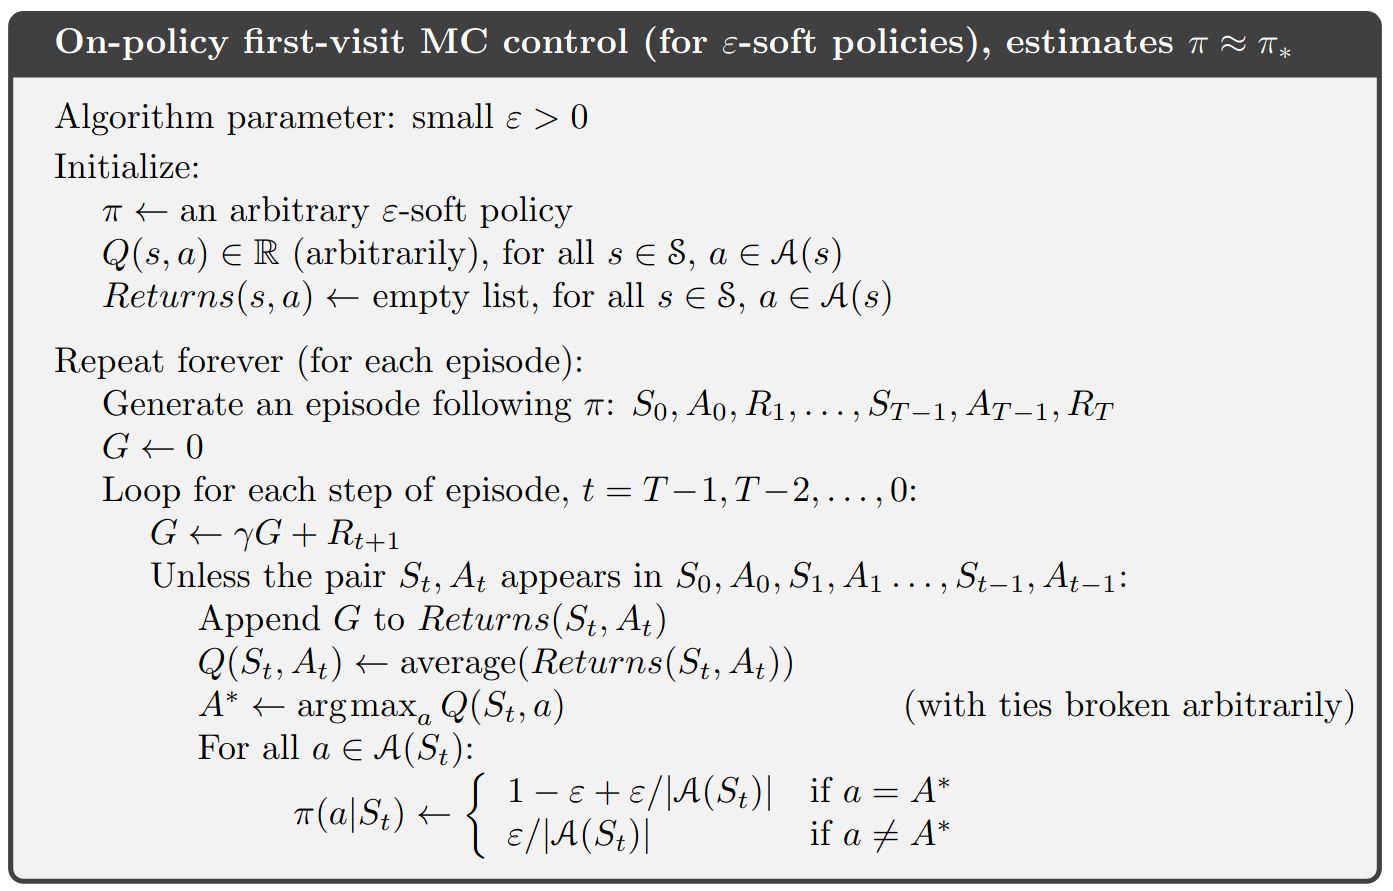

In [ ]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = MC(actor, value_function, env, gamma=0.8, epsilon=0.4)

algorithm.train_on_policy(1_000)

## Off-Policy Monte Carlo Control

### Ordinary Importance Sampling

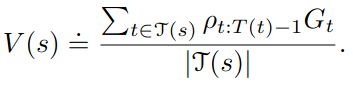

In [ ]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([2, 2]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor_b = Actor(num_states=grid_shape, num_actions=env.action_space.n)
actor_t = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = MC(actor_b, value_function, env,actor_target=actor_t, gamma=0.8, epsilon=0.2)

algorithm.train_off_policy(1_000, weighted_sampling=True)

## Weighted Importance Sampling

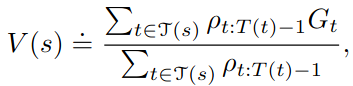

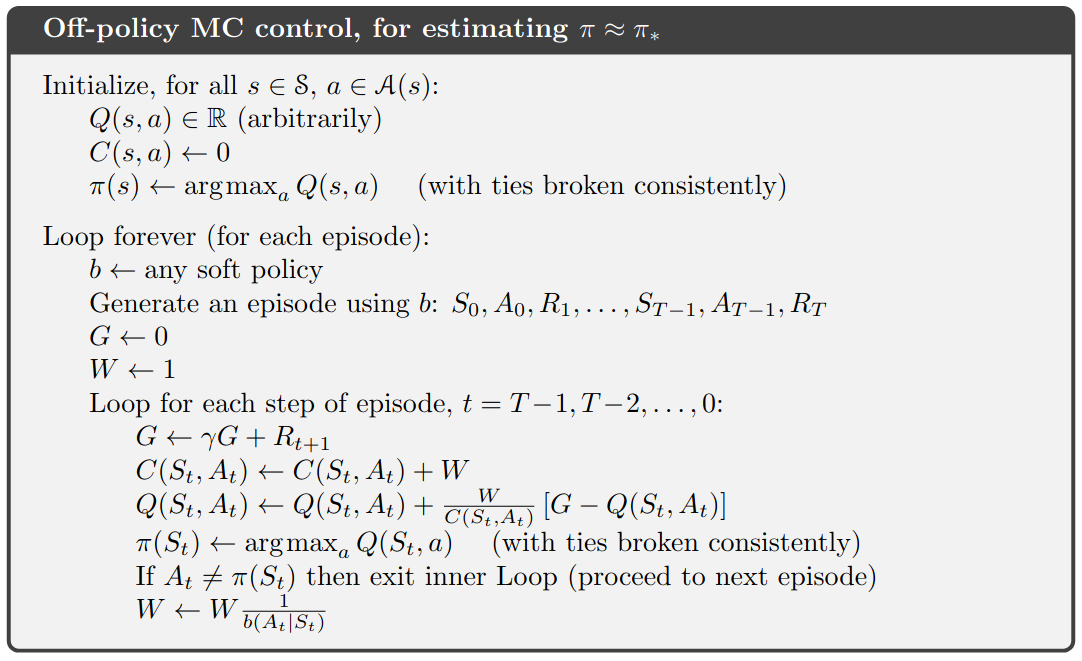

In [ ]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([2, 2]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor_b = Actor(num_states=grid_shape, num_actions=env.action_space.n)
actor_t = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = MC(actor_b, value_function, env,actor_target=actor_t, gamma=0.8, epsilon=0.2)

algorithm.train_off_policy(1_000)

# TD Learning

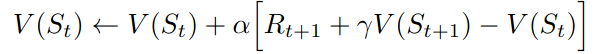

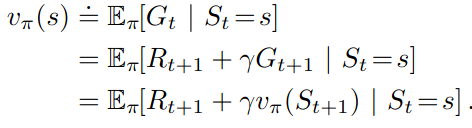

In [29]:
class TD():
    """Collection of Temporal Difference Algorithms for RL"""

    def __init__(
        self,
        actor: Actor,
        value_fct: ActionValueFunction,
        env: gym.Env,
        gamma: float = 0.8,
        alpha: float = 0.1,
        epsilon: float = 0.1,
    ):
        self.actor = actor
        self.env = env
        self.value_function = value_fct

        self.gamma = gamma      # discount factor
        self.alpha = alpha      # learning rate
        self.epsilon = epsilon  # epsilon for epsilon-greedy policy


    def sarsa(self, num_episodes: int):
        """SARSA On-Policy TD Control"""
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            action = self.actor.epsilon_greedy_action(state, self.epsilon)
            terminated = truncated = False

            while not terminated and not truncated:
                state_, reward, terminated, truncated, _ = self.env.step(action)
                # Choose next action using epsilon-greedy
                action_ = self.actor.epsilon_greedy_action(state_, self.epsilon)

                # Update Q-value using SARSA update rule
                q_value = self.value_function.get_value(state, action)
                q_value_ = self.value_function.get_value(state_, action_)

                td_target = reward + self.gamma * q_value_
                td_error = td_target - q_value
                q_val_new = q_value + self.alpha * td_error

                self.value_function.set_value(state, action, q_val_new)

                # Update actor
                action_values = self.value_function.get_action_values_from_state(state)
                self.actor.update_policy_epsilon_greedy(state, action_values, self.epsilon)
                
                state, action = state_, action_


            if episode % 100 == 0:
                plot_gridworld_action(self.value_function, (self.env.unwrapped.size, self.env.unwrapped.size), self.actor)
            
            print(f'Episode {episode} completed.')

    def q_learning(self, num_episodes: int):
        """Q-Learning Off-Policy TD Control"""
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            terminated = truncated = False

            while not terminated and not truncated:
                action = self.actor.epsilon_greedy_action(state, self.epsilon)
                state_, reward, terminated, truncated, _ = self.env.step(action)

                # Update Q-value using Q-learning update rule
                q_value = self.value_function.get_value(state, action)
                best_action_ = self.actor.greedy_action(state_)
                best_action_value_ = self.value_function.get_value(state_, best_action_)

                # calculate
                td_target = reward + self.gamma * best_action_value_
                td_error = td_target - q_value
                q_value_new = q_value + self.alpha * td_error

                self.value_function.set_value(state, action, q_value_new)

                # Update policy
                action_values = self.value_function.get_action_values_from_state(state)
                self.actor.update_policy_epsilon_greedy(state, action_values, self.epsilon)

                state = state_
            
            if episode % 100 == 0:
                plot_gridworld_action(self.value_function, (self.env.unwrapped.size, self.env.unwrapped.size), self.actor)
        
            print(f'Episode {episode} completed.')


    def train_sarsa(self, num_episodes: int):
        print("[Info] - Starting SARSA Algorithm Training")
        self.sarsa(num_episodes)

        return self.value_function, self.actor

    def train_q_learning(self, num_episodes: int):
        print("[Info] - Starting Q-Learning Algorithm Training")
        self.q_learning(num_episodes)

        return self.value_function, self.actor

# SARSA


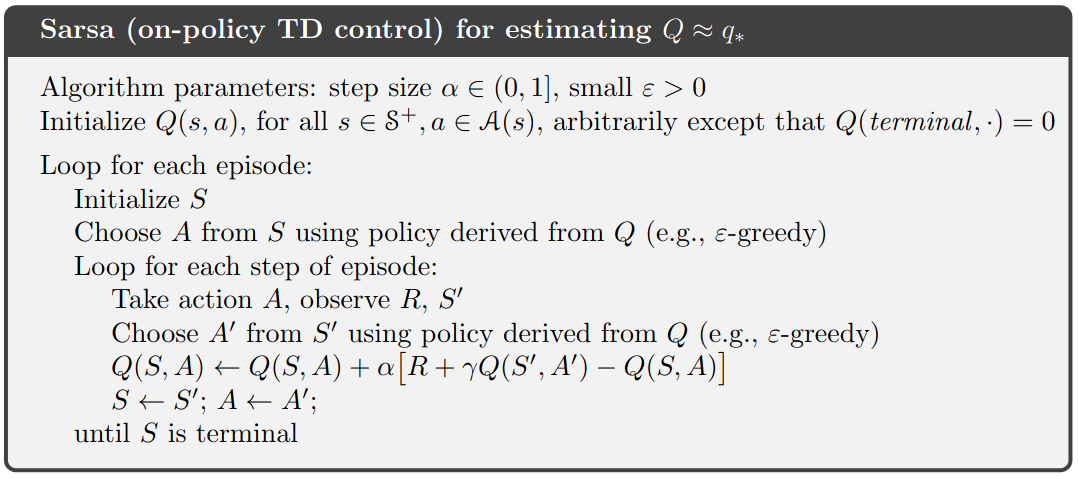

In [ ]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([2, 2]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = TD(actor, value_function, env, gamma=0.8, alpha=0.1, epsilon=0.2)

algorithm.train_sarsa(1_000)

# Q-Learning

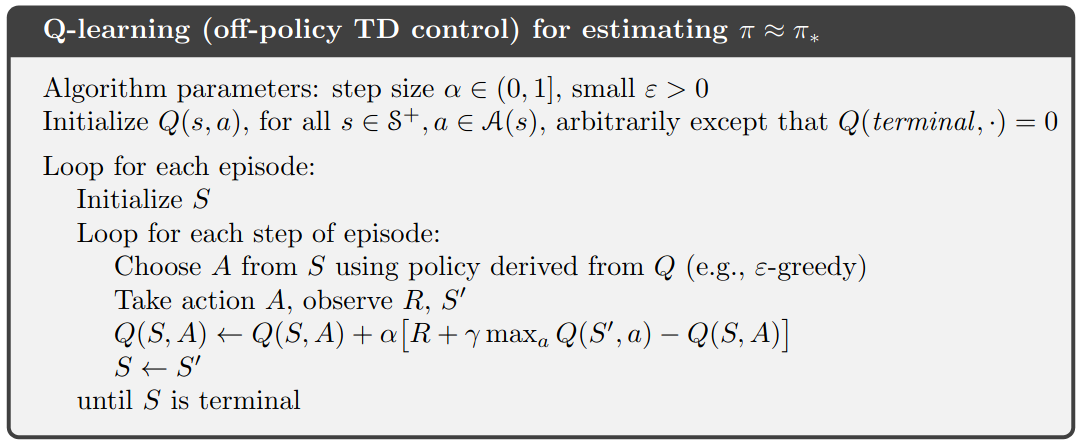

In [ ]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([2, 2]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = TD(actor, value_function, env, gamma=0.8, alpha=0.1, epsilon=0.2)

algorithm.train_q_learning(1_000)